In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
import kaleido

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

In [38]:
df = pd.read_csv('temp_yield.csv')

In [3]:
df.head()

,Country,year,Yield_Value,Tmax,Tmin,avg_temp,avg_spring_temp,avg_winter_temp,HWN,HWM,CWN,CWM,SHWN,SHWM,WCWN,WCWM
0,Afghanistan,1961,10220.0,17.98,-3.92,6.85,8.58,0.44,8.0,1.00,7.0,-2.93,4.0,0.96,3.0,-3.98
1,Afghanistan,1962,9735.0,17.98,-3.92,7.34,7.91,-4.75,4.0,1.43,4.0,-3.12,2.0,1.11,3.0,-3.82
2,Afghanistan,1963,8317.0,17.98,-3.92,5.25,5.76,-0.98,2.0,1.75,9.0,-2.91,0.0,0.00,5.0,-4.29
3,Afghanistan,1964,9510.0,17.95,-3.96,6.14,6.23,-5.22,4.0,0.79,16.0,-2.62,0.0,0.00,8.0,-3.40
4,Afghanistan,1965,9723.0,17.98,-3.92,8.66,11.47,2.16,13.0,1.72,10.0,-2.67,4.0,1.42,6.0,-2.78


In [4]:
df_dropped = df.drop(columns=['Country', 'Tmin', 'Tmax', 'Yield_Value'])
correlation_matrix = df_dropped.corr()
print(correlation_matrix)

                     year  avg_temp  avg_spring_temp  avg_winter_temp  \
year             1.000000  0.002442         0.014686        -0.028423   
avg_temp         0.002442  1.000000         0.979338         0.930226   
avg_spring_temp  0.014686  0.979338         1.000000         0.853753   
avg_winter_temp -0.028423  0.930226         0.853753         1.000000   
HWN              0.559276  0.122960         0.143342         0.077676   
HWM              0.186752 -0.501884        -0.461384        -0.567052   
CWN             -0.438806 -0.194497        -0.183057        -0.193310   
CWM             -0.042003  0.578891         0.530558         0.622667   
SHWN             0.436450  0.101864         0.143084         0.045348   
SHWM             0.204024 -0.424719        -0.387696        -0.486125   
WCWN            -0.267239 -0.228740        -0.198899        -0.249012   
WCWM             0.012994  0.564119         0.514631         0.609438   

                      HWN       HWM       CWN     

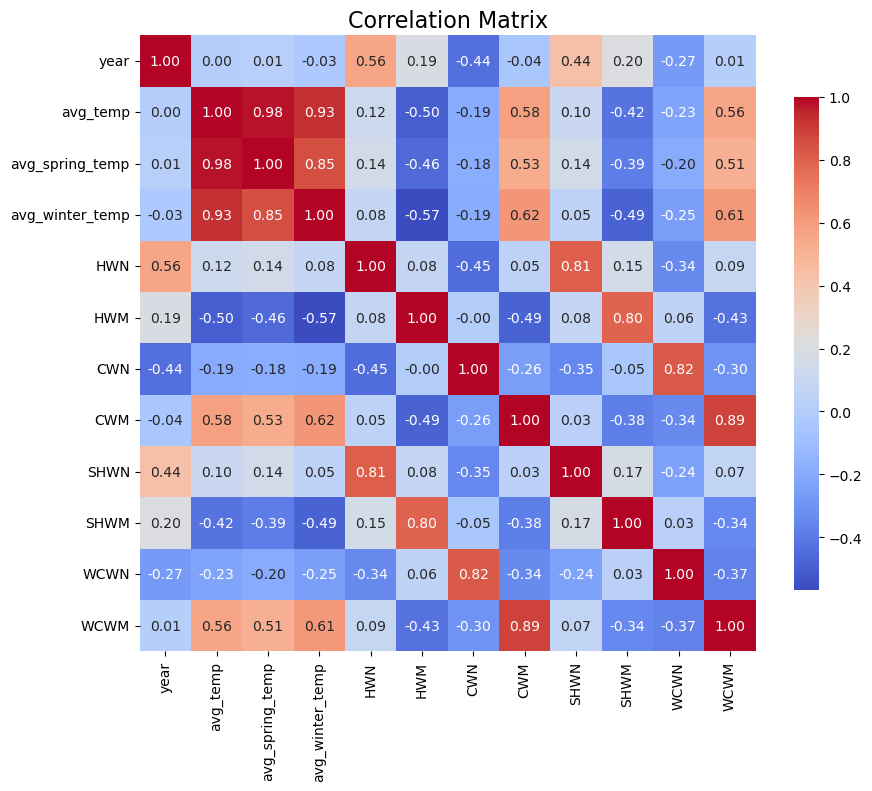

In [5]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [10]:
X = df[['year','avg_temp', 'HWN', 'HWM', 
        'CWN', 'CWM', 'Country']]
y = df['Yield_Value']

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=42)

X_train_plot = X_train
X_test_plot = X_test

In [11]:
numerical_features = ['year','avg_temp', 'HWN', 'HWM', 'CWN', 'CWM']
categorical_features = ['Country']


preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# 2. Training models for v1.0

## A. Random Forest Regressor

In [12]:

param_grid = {
    'n_estimators': [400],
    'max_depth': [20],
    'min_samples_split': [2],
    'min_samples_leaf': [2],
    'bootstrap': [True]
}


rfr = RandomForestRegressor(random_state=0)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', GridSearchCV(estimator=rfr, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
)])

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=42)


pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_pred_train = pipeline.predict(X_train)



mse_test = mean_squared_error(y_test, y_pred)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred)
r2_train = r2_score(y_train, y_pred_train)
mape_test = mean_absolute_percentage_error(y_test, y_pred)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)


best_params = pipeline.named_steps['model'].best_params_
print("Gradient Boosting Regressor performance:")
print(f"Best Parameters: {best_params}")
print(f"Training R²: {r2_train:.4f}")
print(f"Test R²: {r2_test:.4f}")
print(f"Training MSE: {mse_train:.4f}")
print(f"Test MSE: {mse_test:.4f}")
print(f"Training MAPE: {mape_train:.4f}")
print(f"Test MAPE: {mape_test:.4f}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   9.0s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   9.4s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   9.2s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   9.4s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  10.0s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=  13.3s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=  13.3s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=  13.6s
[CV]

## B. Linear Regression

In [13]:

param_grid = {}
lr = LinearRegression()


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler(with_mean=False)),  
    ('model', GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2))
])

pipeline.fit(X_train, y_train)


y_pred = pipeline.predict(X_test)
y_pred_train = pipeline.predict(X_train)


mse_test = mean_squared_error(y_test, y_pred)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred)
r2_train = r2_score(y_train, y_pred_train)
mape_test = mean_absolute_percentage_error(y_test, y_pred)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

best_params = pipeline.named_steps['model'].best_params_
print("Gradient Boosting Regressor performance:")
print(f"Best Parameters: {best_params}")
print(f"Training R²: {r2_train:.4f}")
print(f"Test R²: {r2_test:.4f}")
print(f"Training MSE: {mse_train:.4f}")
print(f"Test MSE: {mse_test:.4f}")
print(f"Training MAPE: {mape_train:.4f}")
print(f"Test MAPE: {mape_test:.4f}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s[CV] END .................................................... total time=   0.0s

[CV] END .................................................... total time=   0.0s
Gradient Boosting Regressor performance:
Best Parameters: {}
Training R²: 0.8481
Test R²: 0.8304
Training MSE: 50470687.0281
Test MSE: 52297387.9967
Training MAPE: 0.3034
Test MAPE: 0.3231


In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])


param_grid = {'alpha': [1.0]}
ridge = Ridge()

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler(with_mean=False)),  
    ('model', GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2))
])


X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=42)


pipeline.fit(X_train, y_train)


y_pred = pipeline.predict(X_test)
y_pred_train = pipeline.predict(X_train)


mse_test = mean_squared_error(y_test, y_pred)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred)
r2_train = r2_score(y_train, y_pred_train)
mape_test = mean_absolute_percentage_error(y_test, y_pred)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)


best_params = pipeline.named_steps['model'].best_params_
print("Gradient Boosting Regressor performance:")
print(f"Best Parameters: {best_params}")
print(f"Training R²: {r2_train:.4f}")
print(f"Test R²: {r2_test:.4f}")
print(f"Training MSE: {mse_train:.4f}")
print(f"Test MSE: {mse_test:.4f}")
print(f"Training MAPE: {mape_train:.4f}")
print(f"Test MAPE: {mape_test:.4f}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s[CV] END ..........................................alpha=1.0; total time=   0.0s

Gradient Boosting Regressor performance:
Best Parameters: {'alpha': 1.0}
Training R²: 0.8481
Test R²: 0.8305
Training MSE: 50473068.7394
Test MSE: 52255887.6538
Training MAPE: 0.3035
Test MAPE: 0.3229


In [15]:
param_grid = {'alpha': [1.0]}
lasso = Lasso()


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler(with_mean=False)),  
    ('model', GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2))
])


X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=42)


pipeline.fit(X_train, y_train)


y_pred = pipeline.predict(X_test)
y_pred_train = pipeline.predict(X_train)


mse_test = mean_squared_error(y_test, y_pred)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred)
r2_train = r2_score(y_train, y_pred_train)

best_params = pipeline.named_steps['model'].best_params_
print("Gradient Boosting Regressor performance:")
print(f"Best Parameters: {best_params}")
print(f"Training R²: {r2_train:.4f}")
print(f"Test R²: {r2_test:.4f}")
print(f"Training MSE: {mse_train:.4f}")
print(f"Test MSE: {mse_test:.4f}")
print(f"Training MAPE: {mape_train:.4f}")
print(f"Test MAPE: {mape_test:.4f}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/jules/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15043583991.13498, tolerance: 144016830.58774763
  model = cd_fast.sparse_enet_coordinate_descent(
/home/jules/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13797143288.995514, tolerance: 142494335.79764214
  model = cd_fast.sparse_enet_coordinate_descent(
/home/jules/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10230371220.605469, tolerance: 146664311.05981624
  model = cd_fast.sparse_enet_coordinate_descent(
/home/jules/anaconda3/lib/python3.12/site-packages/sklearn/

[CV] END ..........................................alpha=1.0; total time=   0.8s
[CV] END ..........................................alpha=1.0; total time=   0.8s
[CV] END ..........................................alpha=1.0; total time=   0.8s
[CV] END ..........................................alpha=1.0; total time=   0.8s
[CV] END ..........................................alpha=1.0; total time=   0.9s
Gradient Boosting Regressor performance:
Best Parameters: {'alpha': 1.0}
Training R²: 0.8481
Test R²: 0.8307
Training MSE: 50490357.7435
Test MSE: 52201160.8955
Training MAPE: 0.3035
Test MAPE: 0.3229


/home/jules/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11955962986.891876, tolerance: 179721476.9867527
  model = cd_fast.sparse_enet_coordinate_descent(


In [16]:
best_model = pipeline.named_steps['model'].best_estimator_
lasso_coefficients = best_model.coef_

feature_names = numerical_features + list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features))
coefficients_with_features = dict(zip(feature_names, lasso_coefficients))

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': best_model.coef_
})


print(feature_importance.head(10))

               Feature  Coefficient
0                 year  6250.542839
1             avg_temp  3151.120605
2                  HWN   -84.895266
3                  HWM   217.958256
4                  CWN   528.930320
5                  CWM  -185.378814
6  Country_Afghanistan  -394.347252
7      Country_Albania   419.734820
8      Country_Algeria -1334.567539
9       Country_Angola -1059.386637


## Gradient Boosting

In [17]:
param_grid = {
    'n_estimators': [500],
    'max_depth': [7],
    'learning_rate': [0.1],
    'subsample': [0.7]
}


gbr = GradientBoostingRegressor(random_state=0)


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2))
])


X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=42)


pipeline.fit(X_train, y_train)


y_pred = pipeline.predict(X_test)
y_pred_train = pipeline.predict(X_train)


mse_test = mean_squared_error(y_test, y_pred)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred)
r2_train = r2_score(y_train, y_pred_train)
mape_test = mean_absolute_percentage_error(y_test, y_pred)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)


best_params = pipeline.named_steps['model'].best_params_

print("Gradient Boosting Regressor performance:")
print(f"Best Parameters: {best_params}")
print(f"Training R²: {r2_train:.4f}")
print(f"Test R²: {r2_test:.4f}")
print(f"Training MSE: {mse_train:.4f}")
print(f"Test MSE: {mse_test:.4f}")
print(f"Training MAPE: {mape_train:.4f}")
print(f"Test MAPE: {mape_test:.4f}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.7; total time=   5.3s
[CV] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.7; total time=   5.3s
[CV] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.7; total time=   5.3s
[CV] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.7; total time=   5.4s
[CV] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.7; total time=   5.5s
Gradient Boosting Regressor performance:
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.7}
Training R²: 0.9932
Test R²: 0.9369
Training MSE: 2261354.1205
Test MSE: 19447369.4782
Training MAPE: 0.0691
Test MAPE: 0.1669


In [18]:

param_grid = {
    'n_estimators': [400],
    'max_depth': [6],
    'learning_rate': [0.1],
    'subsample': [0.7]
}


gbr = GradientBoostingRegressor(random_state=0)


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2))
])


X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=42)


pipeline.fit(X_train, y_train)


y_pred = pipeline.predict(X_test)
y_pred_train = pipeline.predict(X_train)


mse_test = mean_squared_error(y_test, y_pred)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred)
r2_train = r2_score(y_train, y_pred_train)
mape_test = mean_absolute_percentage_error(y_test, y_pred)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

best_params = pipeline.named_steps['model'].best_params_


print("Gradient Boosting Regressor performance:")
print(f"Best Parameters: {best_params}")
print(f"Training R²: {r2_train:.4f}")
print(f"Test R²: {r2_test:.4f}")
print(f"Training MSE: {mse_train:.4f}")
print(f"Test MSE: {mse_test:.4f}")
print(f"Training MAPE: {mape_train:.4f}")
print(f"Test MAPE: {mape_test:.4f}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.1, max_depth=6, n_estimators=400, subsample=0.7; total time=   3.6s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=400, subsample=0.7; total time=   3.6s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=400, subsample=0.7; total time=   3.6s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=400, subsample=0.7; total time=   3.6s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=400, subsample=0.7; total time=   3.7s
Gradient Boosting Regressor performance:
Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 400, 'subsample': 0.7}
Training R²: 0.9818
Test R²: 0.9337
Training MSE: 6056918.4057
Test MSE: 20445607.3000
Training MAPE: 0.1135
Test MAPE: 0.1795


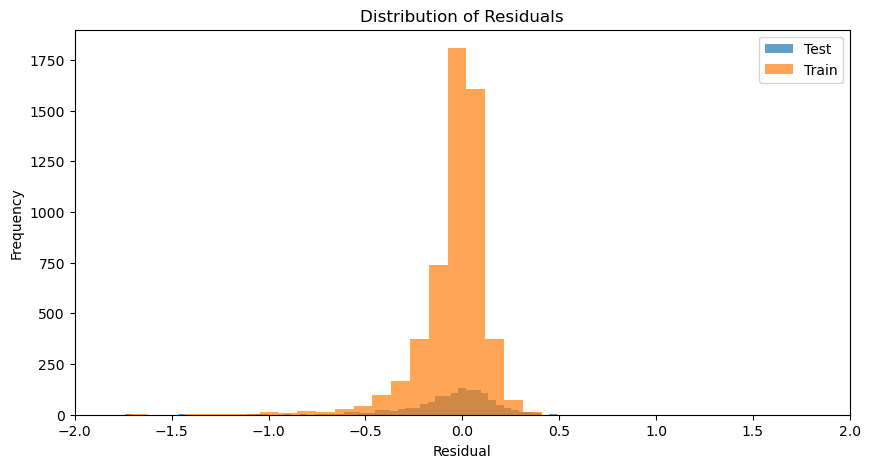

In [19]:
plt.figure(figsize=(10, 5))
plt.hist((y_test - y_pred)/y_test, bins=100, alpha=0.7, label='Test')
plt.hist((y_train - y_pred_train)/y_train, bins=100, alpha=0.7, label='Train')
plt.legend()
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.xlim(-2, 2)
plt.show()

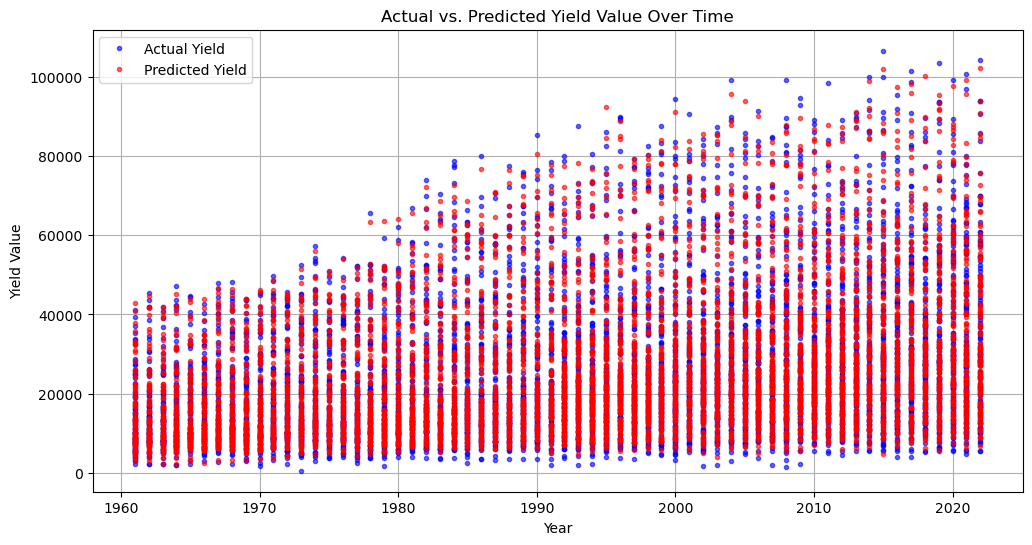

In [20]:
y_pred_all = pipeline.predict(X)


plt.figure(figsize=(12, 6))
plt.plot(df['year'], df['Yield_Value'], label='Actual Yield', color='blue', marker='.', linestyle='None', alpha=0.6)
plt.plot(df['year'], y_pred_all, label='Predicted Yield', color='red',marker='.', linestyle='None', alpha=0.6)
plt.xlabel('Year')
plt.ylabel('Yield Value')
plt.title('Actual vs. Predicted Yield Value Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
df_predictions = pd.DataFrame({
    'year': df['year'],
    'Actual_Yield': df['Yield_Value'],
    'Predicted_Yield': y_pred_all
})


df_grouped_predictions = df_predictions.groupby('year').agg({
    'Actual_Yield': 'mean',
    'Predicted_Yield': 'mean'
}).reset_index()

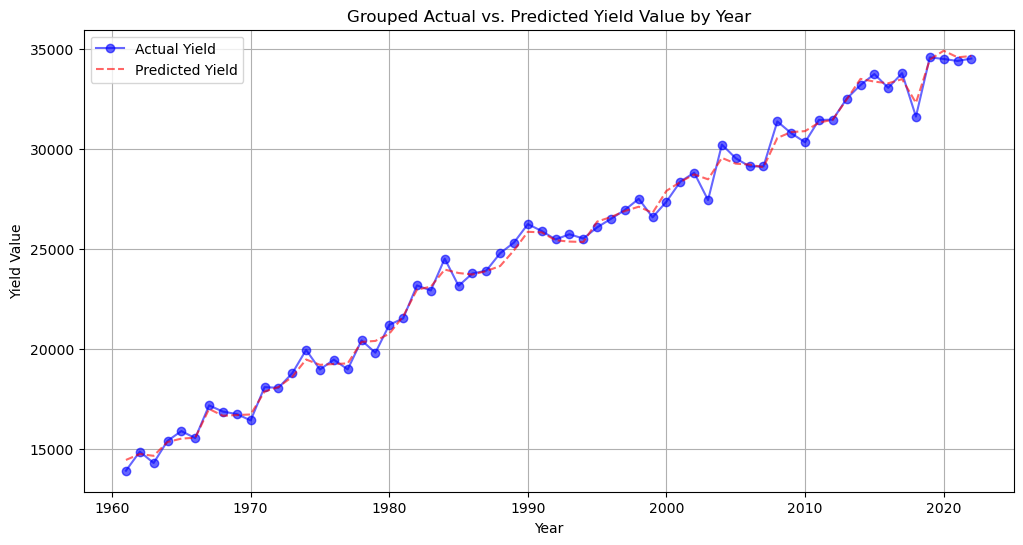

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(df_grouped_predictions['year'], df_grouped_predictions['Actual_Yield'], label='Actual Yield', color='blue', marker='o', linestyle='-', alpha=0.6)
plt.plot(df_grouped_predictions['year'], df_grouped_predictions['Predicted_Yield'], label='Predicted Yield', color='red', linestyle='--', alpha=0.6)
plt.xlabel('Year')
plt.ylabel('Yield Value')
plt.title('Grouped Actual vs. Predicted Yield Value by Year')
plt.legend()
plt.grid(True)
plt.show()

In [41]:

target_countries = ['France', 'India']
df_filtered_countries = df[df['Country'].isin(target_countries)]


X_filtered = df_filtered_countries[['avg_temp', 'HWN', 'HWM', 'CWN', 'CWM', 'Country', 'year']]
y_pred_filtered = pipeline.predict(X_filtered)
df_filtered_countries['Predicted_Yield'] = y_pred_filtered


fig = go.Figure()


for country in target_countries:
    country_data = df_filtered_countries[df_filtered_countries['Country'] == country]
    fig.add_trace(go.Scatter(x=country_data['year'], y=country_data['Yield_Value']/1000,
                             mode='lines', name=f'{country} Actual Yield'))
    fig.add_trace(go.Scatter(x=country_data['year'], y=country_data['Predicted_Yield']/1000,
                             mode='lines', name=f'{country} Predicted Yield', line=dict(dash='dash')))


fig.add_trace(go.Scatter(x=df_grouped_predictions['year'], y=df_grouped_predictions['Actual_Yield']/1000,
                         mode='lines+markers', name='Mean Actual Yield', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=df_grouped_predictions['year'], y=df_grouped_predictions['Predicted_Yield']/1000,
                         mode='lines', name='Mean Predicted Yield', line=dict(color='red', dash='dash')))


fig.update_layout(title='Actual vs. Predicted Yield Value by Year',
                  xaxis_title='Year',
                  yaxis_title='Yield Value (kg/ha)',
                  legend_title='Legend',
                  template='plotly')



fig.show()
#fig.write_image("images/grouped_yield_plot.png")

/tmp/ipykernel_8493/2683229383.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/tmp/ipykernel_8493/916179203.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



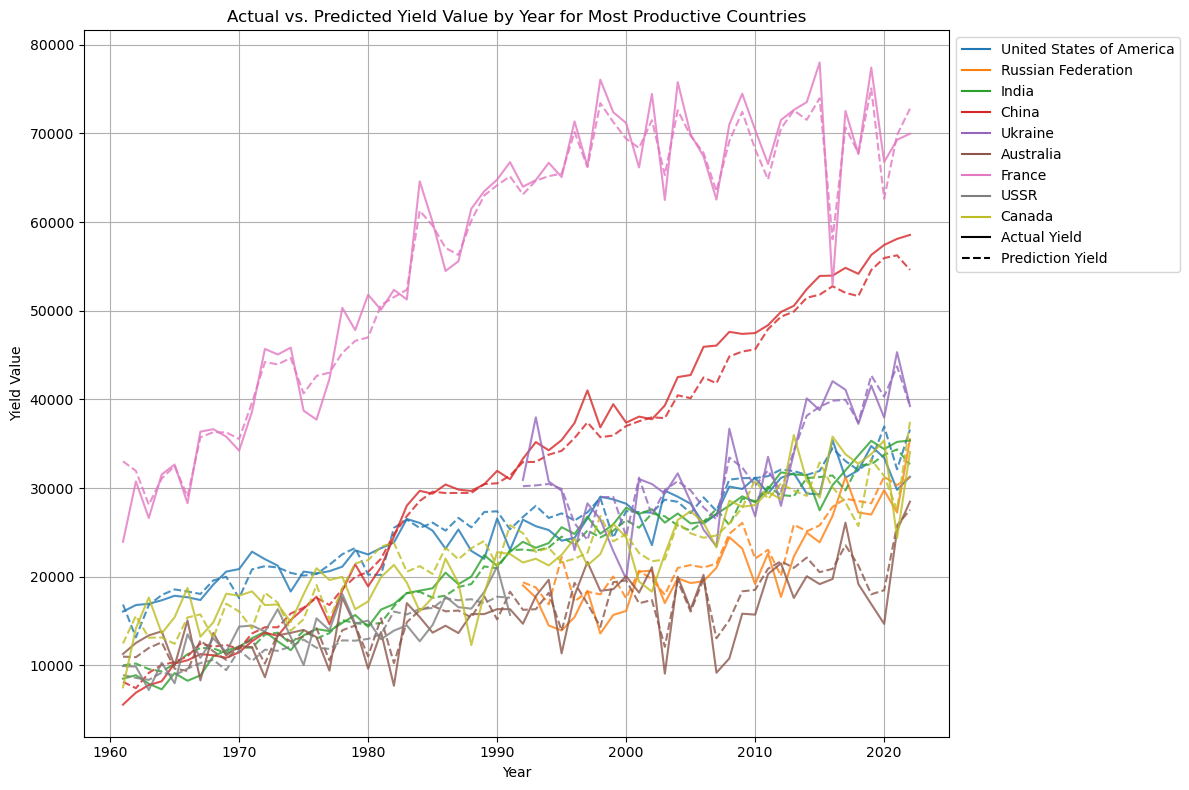

In [42]:
target_countries = ['United States of America', 'Russian Federation', 'India', 'China', 'Ukraine', 'Australia', 'France', 'USSR', 'Canada']

df_filtered_countries = df[df['Country'].isin(target_countries)]

X_filtered = df_filtered_countries[['avg_temp', 'HWN', 'HWM', 'CWN', 'CWM', 'Country', 'year']]
y_pred_filtered = pipeline.predict(X_filtered)

df_filtered_countries['Predicted_Yield'] = y_pred_filtered

plt.figure(figsize=(12, 8))
colors = plt.cm.tab10(range(len(target_countries)))  

for i, country in enumerate(target_countries):
    country_data = df_filtered_countries[df_filtered_countries['Country'] == country]
    plt.plot(country_data['year'], country_data['Yield_Value'], color=colors[i], linestyle='-', alpha=0.8, label=f'{country} AY')
    plt.plot(country_data['year'], country_data['Predicted_Yield'], color=colors[i], linestyle='--', alpha=0.8, label=f'{country} PY')


handles = []
for i, country in enumerate(target_countries):
    handles.append(plt.Line2D([0], [0], color=colors[i], linestyle='-', label=f'{country}'))

handles.extend([
    plt.Line2D([0], [0], color='black', linestyle='-', label='Actual Yield'),
    plt.Line2D([0], [0], color='black', linestyle='--', label='Prediction Yield')
])


plt.xlabel('Year')
plt.ylabel('Yield Value')
plt.title('Actual vs. Predicted Yield Value by Year for Most Productive Countries')
plt.legend(handles=handles, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_8493/2950972267.py:8: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



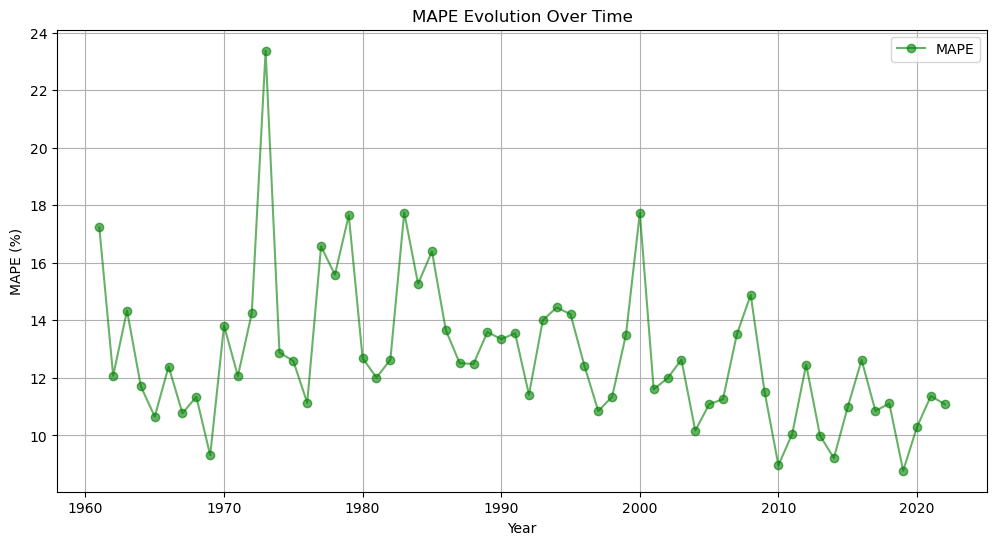

In [43]:
df['Predicted_Yield'] = y_pred_all


def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


df_grouped_mape = df.groupby('year').apply(lambda x: calculate_mape(x['Yield_Value'], x['Predicted_Yield'])).reset_index(name='MAPE')


plt.figure(figsize=(12, 6))
plt.plot(df_grouped_mape['year'], df_grouped_mape['MAPE'], label='MAPE', color='green', marker='o', linestyle='-', alpha=0.6)
plt.xlabel('Year')
plt.ylabel('MAPE (%)')
plt.title('MAPE Evolution Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
mean_temp = df.groupby('Country')['avg_temp'].mean().reset_index()
mean_temp.columns = ['Country', 'mean_temp']

df = df.merge(mean_temp, on='Country', how='left')

df['Temp_Var'] = (df['avg_temp'] - df['mean_temp']) / df['mean_temp'] * 100

df_mape_temp_var = df.groupby(['year', 'Country']).agg({
    'Yield_Value': lambda x: calculate_mape(x, df.loc[x.index, 'Predicted_Yield']),
    'Temp_Var': 'mean'
}).reset_index()

df_mape_temp_var.rename(columns={'Yield_Value': 'MAPE'}, inplace=True)



In [49]:
df

,Country,year,Yield_Value,Tmax,Tmin,avg_temp,avg_spring_temp,avg_winter_temp,HWN,HWM,CWN,CWM,SHWN,SHWM,WCWN,WCWM,Predicted_Yield,mean_temp,Temp_Var
0,Afghanistan,1961,10220.0,17.98,-3.92,6.85,8.58,0.44,8.0,1.00,7.0,-2.93,4.0,0.96,3.0,-3.98,9514.805674,7.884516,-13.120858
1,Afghanistan,1962,9735.0,17.98,-3.92,7.34,7.91,-4.75,4.0,1.43,4.0,-3.12,2.0,1.11,3.0,-3.82,9108.873386,7.884516,-6.906145
2,Afghanistan,1963,8317.0,17.98,-3.92,5.25,5.76,-0.98,2.0,1.75,9.0,-2.91,0.0,0.00,5.0,-4.29,7965.430094,7.884516,-33.413796
3,Afghanistan,1964,9510.0,17.95,-3.96,6.14,6.23,-5.22,4.0,0.79,16.0,-2.62,0.0,0.00,8.0,-3.40,9027.527113,7.884516,-22.125849
4,Afghanistan,1965,9723.0,17.98,-3.92,8.66,11.47,2.16,13.0,1.72,10.0,-2.67,4.0,1.42,6.0,-2.78,10002.052101,7.884516,9.835529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6755,Zimbabwe,2018,27178.0,30.63,13.23,21.47,19.79,23.69,7.0,1.22,2.0,-1.50,1.0,2.44,1.0,-1.62,30087.640163,21.565484,-0.442762
6756,Zimbabwe,2019,39149.0,30.63,13.23,22.41,21.47,24.31,8.0,1.06,3.0,-1.29,2.0,1.03,2.0,-1.24,35737.393283,21.565484,3.916055
6757,Zimbabwe,2020,47796.0,30.63,13.24,22.03,19.96,24.29,9.0,1.31,2.0,-0.74,2.0,1.03,1.0,-0.86,45131.157249,21.565484,2.153980
6758,Zimbabwe,2021,50759.0,30.63,13.23,22.09,20.86,24.62,11.0,1.29,5.0,-0.74,2.0,1.57,3.0,-0.79,46463.344456,21.565484,2.432202


/tmp/ipykernel_8493/2475853557.py:10: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



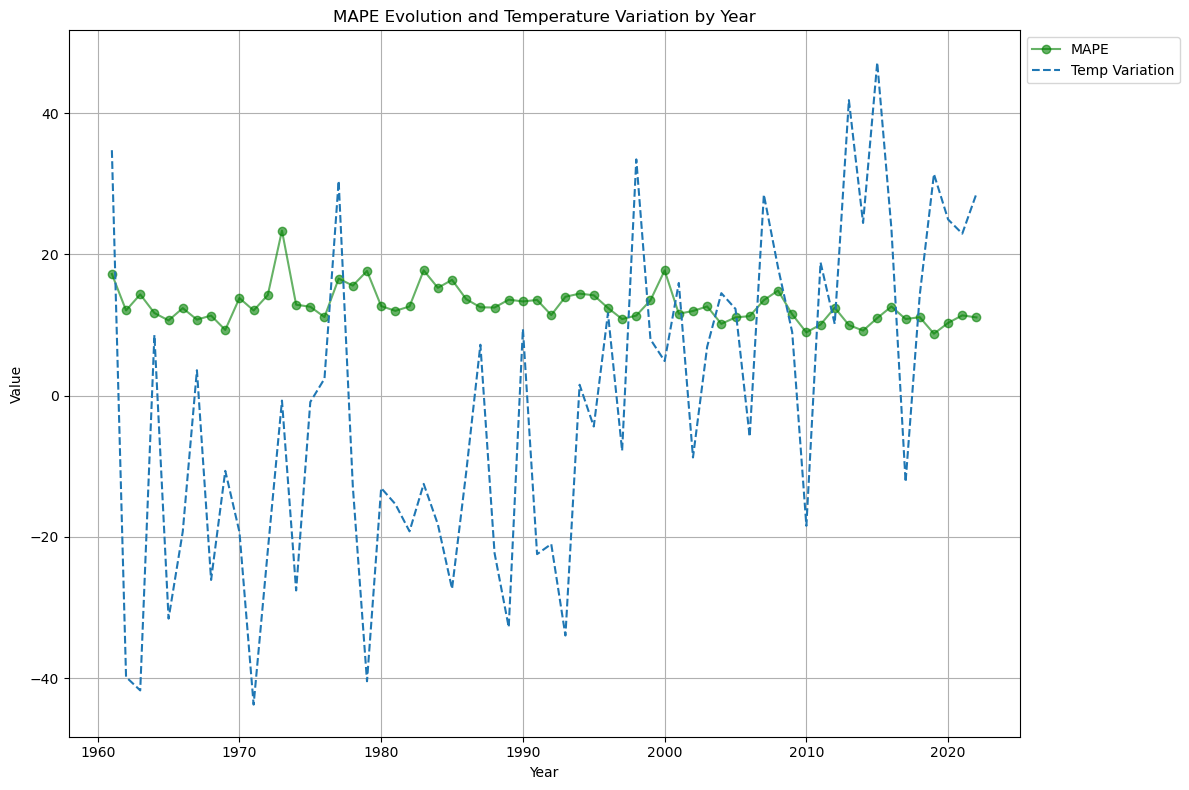

In [50]:
plt.figure(figsize=(12, 8))
X_all = df[['avg_temp', 'HWN', 'HWM', 'CWN', 'CWM', 'Country', 'year']]
df['Predicted_Yield'] = y_pred_all


def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


df_grouped_mape = df.groupby('year').apply(lambda x: calculate_mape(x['Yield_Value'], x['Predicted_Yield'])).reset_index(name='MAPE')

plt.plot(df_grouped_mape['year'], df_grouped_mape['MAPE'], label='MAPE', color='green', marker='o', linestyle='-', alpha=0.6)
plt.plot(country_data['year'], df.groupby('year')['Temp_Var'].mean().reset_index()['Temp_Var'], label='Temp Variation', linestyle='--')


plt.xlabel('Year')
plt.ylabel('Value')
plt.title('MAPE Evolution and Temperature Variation by Year')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()


In [53]:
df_grouped_mape['Temp_Var'] = df.groupby('year')['Temp_Var'].mean().reset_index()['Temp_Var']
correlation = df_grouped_mape[['MAPE', 'Temp_Var']].corr().loc['MAPE', 'Temp_Var']

mean_features = df.groupby('Country')[['CWN', 'HWN', 'CWM', 'HWM']].mean().reset_index()
mean_features.columns = ['Country', 'mean_CWN', 'mean_HWN', 'mean_CWM', 'mean_HWM']

df = df.merge(mean_features, on='Country', how='left')

df['CWN_Var'] = (df['CWN'] - df['mean_CWN']) / df['mean_CWN'] * 100
df['HWN_Var'] = (df['HWN'] - df['mean_HWN']) / df['mean_HWN'] * 100
df['CWM_Var'] = (df['CWM'] - df['mean_CWM']) / df['mean_CWM'] * 100
df['HWM_Var'] = (df['HWM'] - df['mean_HWM']) / df['mean_HWM'] * 100


df['Predicted_Yield'] = y_pred_all

df_grouped_mape = df.groupby('year').agg({
    'Yield_Value': lambda x: calculate_mape(x, df.loc[x.index, 'Predicted_Yield']),
    'CWN_Var': 'mean',
    'HWN_Var': 'mean',
    'CWM_Var': 'mean',
    'HWM_Var': 'mean'
}).reset_index()

df_grouped_mape.rename(columns={'Yield_Value': 'MAPE'}, inplace=True)

correlation_CWN = df_grouped_mape[['MAPE', 'CWN_Var']].corr().loc['MAPE', 'CWN_Var']
correlation_HW = df_grouped_mape[['MAPE', 'HWN_Var']].corr().loc['MAPE', 'HWN_Var']
correlation_CWM = df_grouped_mape[['MAPE', 'CWM_Var']].corr().loc['MAPE', 'CWM_Var']
correlation_HWM = df_grouped_mape[['MAPE', 'HWM_Var']].corr().loc['MAPE', 'HWM_Var']

print(f"Correlation between MAPE and Average Temperature Variation: {correlation:.4f}")
print(f"Correlation between MAPE and Average CWN Variation: {correlation_CWN:.4f}")
print(f"Correlation between MAPE and Average HWN Variation: {correlation_HW:.4f}")
print(f"Correlation between MAPE and Average CWM Variation: {correlation_CWM:.4f}")
print(f"Correlation between MAPE and Average HWM Variation: {correlation_HWM:.4f}")


Correlation between MAPE and Average Temperature Variation: -0.2036
Correlation between MAPE and Average CWN Variation: 0.2997
Correlation between MAPE and Average HWN Variation: -0.3986
Correlation between MAPE and Average CWM Variation: 0.1519
Correlation between MAPE and Average HWM Variation: -0.3956
